In [1]:
FOLD=7
N_QUANTILES = 8

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from projects.IJCARS_2023.src.training import convert_patchwise_to_corewise_dataframe

In [3]:
acc_reject_curves_patchwise = {}
acc_reject_curves_corewise = {}

In [4]:
from sklearn.metrics import roc_auc_score

def add_mps(df):
    prob_1 = df.prob_1.values
    mps = np.max(np.stack([prob_1, 1-prob_1], axis=1), axis=1)
    df['mps'] = mps

def auroc_for_confidence_quantiles(probs, labels, confidence, n_quantiles):
    aurocs = []
    for q in range(0, n_quantiles):
        quantile = np.quantile(confidence, q / n_quantiles)
        mask = confidence >= quantile
        if np.sum(mask) > 0:
            try: 
                aurocs.append(roc_auc_score(labels[mask], probs[mask]))
            except ValueError:
                aurocs.append(np.nan)
    return aurocs

def corewise_auc_for_patchwise_confidence_quantiles(patch_probs, patch_labels, patch_confidence, core_assignments, n_quantiles):
    corewise_aucs = []
    for q in range(0, n_quantiles):
        quantile = np.quantile(patch_confidence, q / n_quantiles)
        mask = patch_confidence >= quantile
        if np.sum(mask) > 0:
            patch_probs_masked = patch_probs[mask]
            patch_labels_masked = patch_labels[mask]
            core_assignments_masked = core_assignments[mask]

            core_probs = []
            core_labels = []
            for core_id in np.unique(core_assignments_masked):
                core_probs.append(np.mean(patch_probs_masked[core_assignments_masked == core_id]))
                core_labels.append(patch_labels_masked[core_assignments_masked == core_id][0])

            corewise_aucs.append(roc_auc_score(core_labels, core_probs))

    return corewise_aucs

## Ensemble + Late calibration

In [5]:

ALL_CURVES_PATCHWISE = []
ALL_CURVES_COREWISE = []

for FOLD in range(10):
    print(FOLD)
    NAME = "ensemble_late_tc"

    acc_reject_curves_patchwise = {}
    acc_reject_curves_corewise = {}

    import os 
    def find_dataframe_paths_ensemble(fold):
        path = f'/h/pwilson/projects/TRUSnet/projects/IJCARS_2023/outputs/ensemble_fold_nocal{fold}'
        path = os.path.join(path, os.listdir(path)[0],)
        return os.path.join(path, 'test_patchwise_ensemble_late_tc.csv'), os.path.join(path, 'val_patchwise_ensemble_late_tc.csv')

    patchwise_test_path, patchwise_val_path = find_dataframe_paths_ensemble(FOLD)

    test_df = pd.read_csv(patchwise_test_path)
    val_df = pd.read_csv(patchwise_val_path)

    from projects.IJCARS_2023.utils import apply_temperature_calibration
    val_df, test_df = apply_temperature_calibration(val_df, test_df, lr=1e-2)

    add_mps(test_df)

    acc_reject_curves_patchwise[NAME] = auroc_for_confidence_quantiles(test_df.prob_1.values, test_df.y.values, test_df.mps.values, N_QUANTILES)

    test_df_corewise = convert_patchwise_to_corewise_dataframe(test_df)
    val_df_corewise = convert_patchwise_to_corewise_dataframe(val_df)

    add_mps(test_df_corewise)
    acc_reject_curves_corewise[NAME] = auroc_for_confidence_quantiles(test_df_corewise.prob_1.values, test_df_corewise.y.values, test_df_corewise.mps.values, N_QUANTILES)

    NAME = 'sngp_tc'

    import os 
    def find_dataframe_paths(toplevel, fold):
        one_path_down = os.path.join(toplevel, os.listdir(toplevel)[0])
        fold_dir = os.path.join(one_path_down, f'fold_{fold}')
        metrics = pd.read_csv(os.path.join(fold_dir, 'metrics.csv'))
        best_epoch = metrics['val/core_auc'].argmax() + 1
        dir_ = os.path.join(fold_dir, 'checkpoints', f'epoch_{best_epoch}')
        return os.path.join(dir_, 'test_patchwise.csv'), os.path.join(dir_, 'val_patchwise.csv')

    test_df_path, val_df_path = find_dataframe_paths('/h/pwilson/projects/TRUSnet/projects/IJCARS_2023/outputs/sngp_round2', FOLD)

    test_df = pd.read_csv(test_df_path)
    val_df = pd.read_csv(val_df_path)

    from projects.IJCARS_2023.utils import apply_temperature_calibration
    val_df, test_df = apply_temperature_calibration(val_df, test_df, lr=1e-2)
    add_mps(test_df)
    acc_reject_curves_patchwise[NAME] = auroc_for_confidence_quantiles(test_df.prob_1.values, test_df.y.values, test_df.mps.values, N_QUANTILES)
    test_df_corewise = convert_patchwise_to_corewise_dataframe(test_df)
    add_mps(test_df_corewise)
    acc_reject_curves_corewise[NAME] = auroc_for_confidence_quantiles(test_df_corewise.prob_1.values, test_df_corewise.y.values, test_df_corewise.mps.values, N_QUANTILES)

    NAME = 'isomax_tc'

    test_df_path, val_df_path = find_dataframe_paths('/h/pwilson/projects/TRUSnet/projects/IJCARS_2023/outputs/isomax_kfold', FOLD)

    test_df = pd.read_csv(test_df_path)
    val_df = pd.read_csv(val_df_path)

    from projects.IJCARS_2023.utils import apply_temperature_calibration
    val_df, test_df = apply_temperature_calibration(val_df, test_df, lr=1e-2)
    add_mps(test_df)
    acc_reject_curves_patchwise[NAME] = auroc_for_confidence_quantiles(test_df.prob_1.values, test_df.y.values, test_df.mps.values, N_QUANTILES)
    test_df_corewise = convert_patchwise_to_corewise_dataframe(test_df)
    add_mps(test_df_corewise)
    acc_reject_curves_corewise[NAME] = auroc_for_confidence_quantiles(test_df_corewise.prob_1.values, test_df_corewise.y.values, test_df_corewise.mps.values, N_QUANTILES)

    NAME = 'vanilla_tc'

    test_df_path, val_df_path = find_dataframe_paths('/h/pwilson/projects/TRUSnet/projects/IJCARS_2023/outputs/vanilla_kfold', FOLD)

    test_df = pd.read_csv(test_df_path)
    val_df = pd.read_csv(val_df_path)

    from projects.IJCARS_2023.utils import apply_temperature_calibration
    val_df, test_df = apply_temperature_calibration(val_df, test_df, lr=1e-2)
    add_mps(test_df)
    acc_reject_curves_patchwise[NAME] = auroc_for_confidence_quantiles(test_df.prob_1.values, test_df.y.values, test_df.mps.values, N_QUANTILES)
    test_df_corewise = convert_patchwise_to_corewise_dataframe(test_df)
    add_mps(test_df_corewise)
    acc_reject_curves_corewise[NAME] = auroc_for_confidence_quantiles(test_df_corewise.prob_1.values, test_df_corewise.y.values, test_df_corewise.mps.values, N_QUANTILES)

    acc_reject_curves_corewise['fold'] = FOLD 
    acc_reject_curves_patchwise['fold'] = FOLD

    ALL_CURVES_COREWISE.append(acc_reject_curves_corewise)
    ALL_CURVES_PATCHWISE.append(acc_reject_curves_patchwise)


0


/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/project

1


/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/project

2


/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/project

3


/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/project

4


/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/project

5


/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/project

6


/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/project

7


/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/project

8


/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/project

9


/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/projects/TRUSnet/trusnet/utils/calibration.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).squeeze()
/ssd003/home/pwilson/project

In [6]:
corewise_data = []
for curves in ALL_CURVES_COREWISE:
    curves = curves.copy()
    fold = curves.pop('fold')
    for name, value in curves.items():
        for i, v in enumerate(value):
            pct_reject = i / N_QUANTILES * 100 
            auroc = v 
            corewise_data.append(
                {
                    'fold': fold,
                    'name': name,
                    'pct_reject': pct_reject,
                    'auroc': auroc
                }
            )

corewise_data = pd.DataFrame(corewise_data)

patchwise_data = []
for curves in ALL_CURVES_PATCHWISE:
    curves = curves.copy()
    fold = curves.pop('fold')
    for name, value in curves.items():
        for i, v in enumerate(value):
            pct_reject = i / N_QUANTILES * 100 
            auroc = v 
            patchwise_data.append(
                {
                    'fold': fold,
                    'name': name,
                    'pct_reject': pct_reject,
                    'auroc': auroc
                }
            )

In [7]:
patchwise_data = pd.DataFrame(patchwise_data)

In [8]:
patchwise_data.to_csv('patchwise_data.csv')
corewise_data.to_csv('corewise_data.csv')

In [9]:
!pip install -U seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times new roman' not found.
findfont: Font family 'times ne

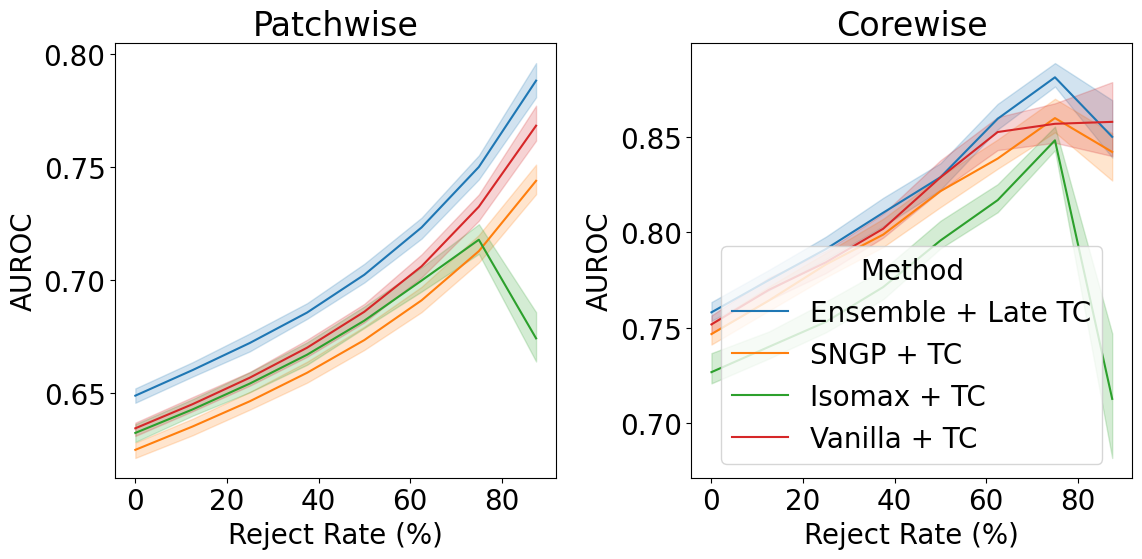

In [ ]:
corewise_data = pd.read_csv('corewise_data.csv', index_col=0)

corewise_data = corewise_data.rename(columns={
    'name': 'Method', 
    'pct_reject': 'Reject Rate (%)',
    'auroc': 'AUROC',
})

method_name_map = {
    'vanilla_tc': 'Vanilla + TC',
    'sngp_tc': 'SNGP + TC',
    'ensemble_late_tc': 'Ensemble + Late TC',
    'isomax_tc': 'Isomax + TC',
}

corewise_data['Method'] = corewise_data['Method'].map(method_name_map)

patchwise_data = pd.read_csv('patchwise_data.csv', index_col=0)

patchwise_data = patchwise_data.rename(columns={
    'name': 'Method',
    'pct_reject': 'Reject Rate (%)',
    'auroc': 'AUROC',
})

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20, 'font.family': 'times new roman'})

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=patchwise_data, x='Reject Rate (%)', y='AUROC', hue='Method', errorbar=('ci', 50), ax=ax[0], legend=False)
ax[0].set_title('Patchwise')

sns.lineplot(data=corewise_data, x='Reject Rate (%)', y='AUROC', hue='Method', errorbar=('ci', 50), ax=ax[1], legend=True)
ax[1].set_title('Corewise')

fig.tight_layout()

<Axes: xlabel='pct_reject', ylabel='auroc'>

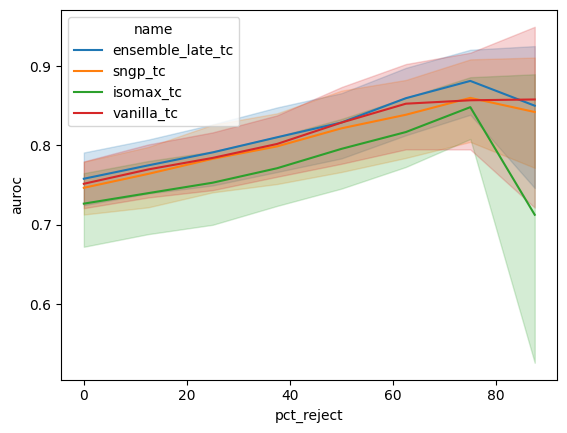

In [10]:
import seaborn as sns

sns.lineplot(data=corewise_data, x='pct_reject', y='auroc', hue='name')